In [100]:
from collections import Counter
import math

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
# from google.colab import drive
import pandas as pd
import seaborn as sns
from sklearn import model_selection, metrics
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
# import eli5

from math import ceil
# drive.mount('/content/drive', force_remount=True)
sns.set_theme()

In [101]:
# LOAD DATA
coup = pd.read_csv("coup_merged_v2.csv").drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.2'], axis=1)
coup['country'] = np.where(coup.country == 'Ecudaor', 'Ecuador',
                           np.where(coup.country == 'Surinam', 'Suriname', coup.country))
#coup = coup[coup.country != 'Sudan']
coup.reset_index(inplace=True)

In [102]:
# SPLIT PREDICTORS AND RESPONSE VARIABLE
X = coup[['military',
       'dissident', 'rebel', 'palace', 'foreign', 'auto', 'resign', 'popular',
       'counter', 'other']]
y = coup.realized

# RF, GradBoost, DecisionTree, Bagging, Adaboost

# Feature Importance & EDA

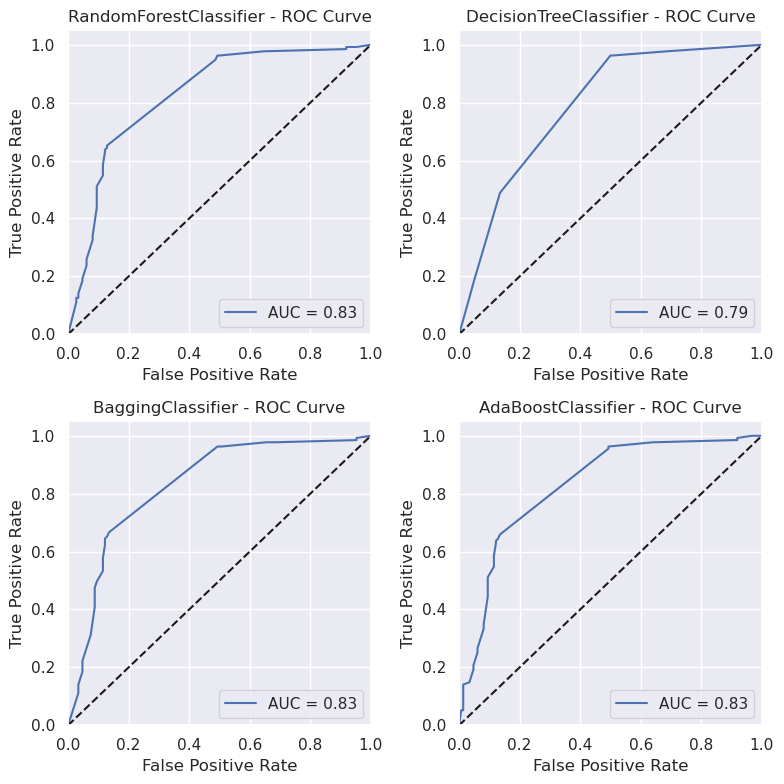

In [103]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Adaboost best hyperparameters
best_max_depth = 4
best_n_estimators = 176
learning_rate = 0.05

# Train a range of models
models = []
models.append(RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train))
models.append(DecisionTreeClassifier(max_depth=3, random_state=42).fit(X_train, y_train))
models.append(BaggingClassifier(random_state=42).fit(X_train, y_train))
models.append(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=best_max_depth),
                                n_estimators=best_n_estimators,
                                learning_rate=learning_rate).fit(X_train, y_train))


fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.ravel()

for ax, (i, clf) in zip(axes, enumerate(models)):
    preds = clf.predict_proba(X_test)[:,1]

    # Calculate true positive rate and false positive rate
    fpr, tpr, _ = metrics.roc_curve(y_test, preds)

    # Calculate area under the curve (AUC)
    auc = metrics.roc_auc_score(y_test, preds)

    # Plot ROC curve
    ax.plot(fpr, tpr, label='AUC = %0.2f' % auc)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{clf.__class__.__name__} - ROC Curve')
    ax.legend(loc="lower right")
plt.tight_layout()


RandomForestClassifier accuracy score: 0.7632508833922261
RandomForestClassifier Feature importance:
{'other': 0.006845371570486268, 'foreign': 0.02846501628700241, 'rebel': 0.03253212044520726, 'counter': 0.03389457865662836, 'auto': 0.044665705667885525, 'resign': 0.06558301304509903, 'palace': 0.07817663394155108, 'military': 0.07914295318786592, 'popular': 0.13436923259929334, 'dissident': 0.4963253745989808}


DecisionTreeClassifier accuracy score: 0.6855123674911661
DecisionTreeClassifier Feature importance:
{'rebel': 0.0, 'foreign': 0.0, 'auto': 0.0, 'counter': 0.0, 'other': 0.0, 'palace': 0.006369457817035806, 'resign': 0.016404385133444967, 'popular': 0.10325680847706514, 'military': 0.1374003999840361, 'dissident': 0.736568948588418}


BaggingClassifier accuracy score: 0.7632508833922261
BaggingClassifier Feature importance:
{'other': 0.007666235053100619, 'auto': 0.020639325661374604, 'foreign': 0.025079758498240855, 'rebel': 0.030275789880638483, 'counter': 0.04333902543792

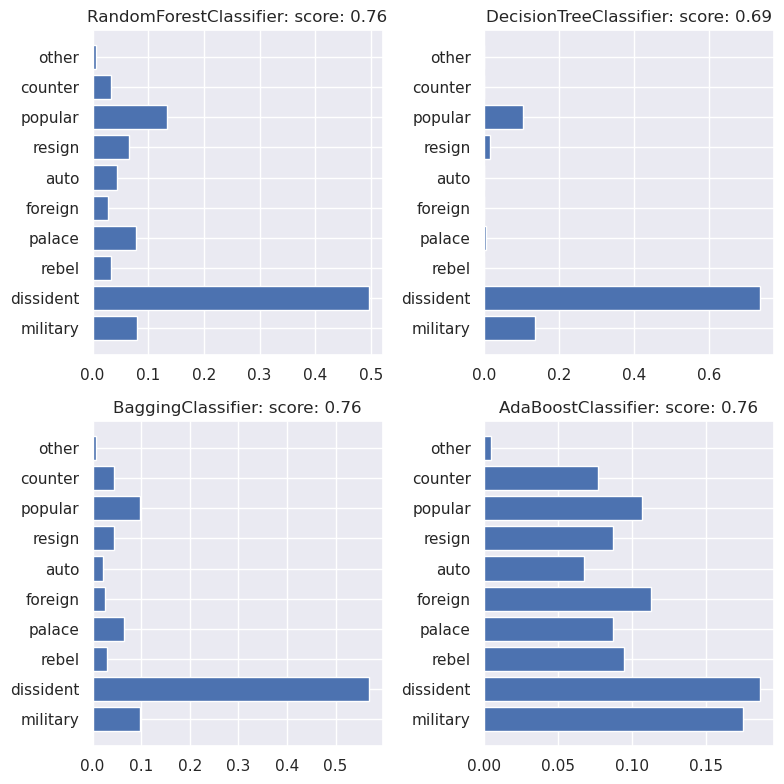

In [104]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.ravel()

# Evaluate the performance of each model on the test set and plot features by feature importance
for ax, (i, clf) in zip(axes, enumerate(models)):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print(f'{clf.__class__.__name__} accuracy score: {score}')

    #Print the feature importance of each predictor variable
    if i == 0 or i ==1:
        importances = clf.feature_importances_
    else:
        importances = np.mean([tree.feature_importances_ for tree in clf.estimators_], axis=0)

    output = {fn: fi for fn, fi in zip(X_train.columns, importances)}

    sorted_out = dict(sorted(output.items(), key=lambda item: item[1]))
    
    print(f'{clf.__class__.__name__} Feature importance:')
    print(sorted_out)
    print("\n")

    names = list(output.keys())
    values = list(output.values())

    ax.barh(range(len(output)), values, tick_label=names)
    ax.set_title(f'{clf.__class__.__name__}: score: {score:.2f}')
plt.tight_layout()

<AxesSubplot:>

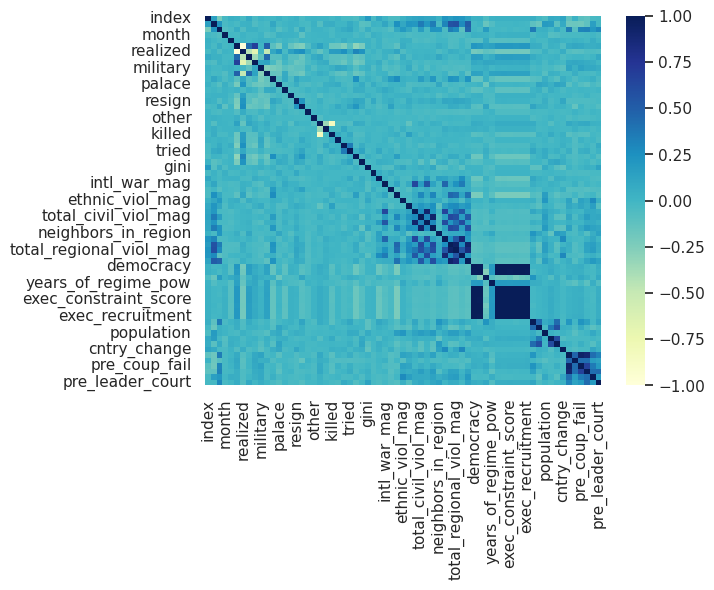

In [105]:
sns.heatmap(coup.corr(), cmap="YlGnBu")

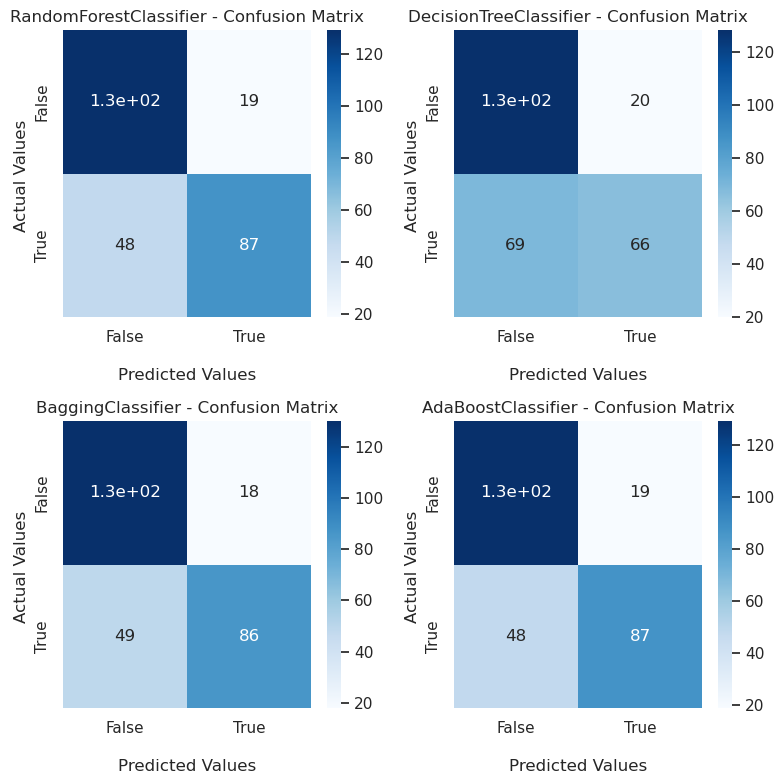

In [106]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
# axes[1][1].set_visible(False)
axes = axes.ravel()

# Evaluate the performance of each model on the test set and plot features by feature importance
for ax, (i, clf) in zip(axes, enumerate(models)):
    cf_matrix = confusion_matrix(y_test, clf.predict(X_test))

    sns.heatmap(cf_matrix, annot=True, cmap='Blues', ax=ax)

    ax.set_title(f'{clf.__class__.__name__} - Confusion Matrix');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
plt.tight_layout()
plt.show()